## Creating a correspondance table between the models

In [27]:
import pandas as pd
import geopandas as gpd
import pycountry
from fuzzywuzzy import process

### Wiliam regions



In [28]:
wiliam = pd.read_excel('regions_WILIAM.xlsx', sheet_name="Regions", skiprows=1, usecols="B:F")

wiliam = wiliam.ffill(axis=0)
wiliam.rename(columns={'ICIO Code (matches with ALPHA-3 excepting for ROW)':'ICIO Code', 'LOCOMOTION global regions': 'WILIAM region', 'LOCOMOTION acronym':"WILIAM code"}, inplace=True)

wiliam['REGIONS 35 I'] = wiliam['WILIAM code'].str.replace(' ', '')
wiliam.loc[wiliam['WILIAM code'] == 'EU27', 'REGIONS 35 I'] = wiliam['Countries']
wiliam['REGIONS 35 I'] = wiliam['REGIONS 35 I'].str.upper()

#wiliam.loc[wiliam['WILIAM code'] != 'EU27', 'WILIAM country'] = wiliam['WILIAM code']


wiliam

,WILIAM region,WILIAM code,Countries,ICIO Code,ALPHA-2 code,REGIONS 35 I
0,European Union,EU27,Austria,AUT,AT,AUSTRIA
1,European Union,EU27,Belgium,BEL,BE,BELGIUM
2,European Union,EU27,Bulgaria,BGR,BG,BULGARIA
3,European Union,EU27,Croatia,HRV,HR,CROATIA
4,European Union,EU27,Cyprus,CYP,CY,CYPRUS
...,...,...,...,...,...,...
63,Rest of the world,LROW,Turkey,TUR,TR,LROW
64,Rest of the world,LROW,South Africa,ZAF,ZA,LROW
65,Rest of the world,LROW,South Africa,ZAF,ZA,LROW
66,Rest of the world,LROW,South Africa,ZAF,ZA,LROW


Now we have to match these regions back with WILIAM's regions. We asked ChatGPT to provide a list of the region of each country from the map available in the WILIAM documentation. 

![wiliam_regions.jpg](<attachment:Sans titre.jpg>)

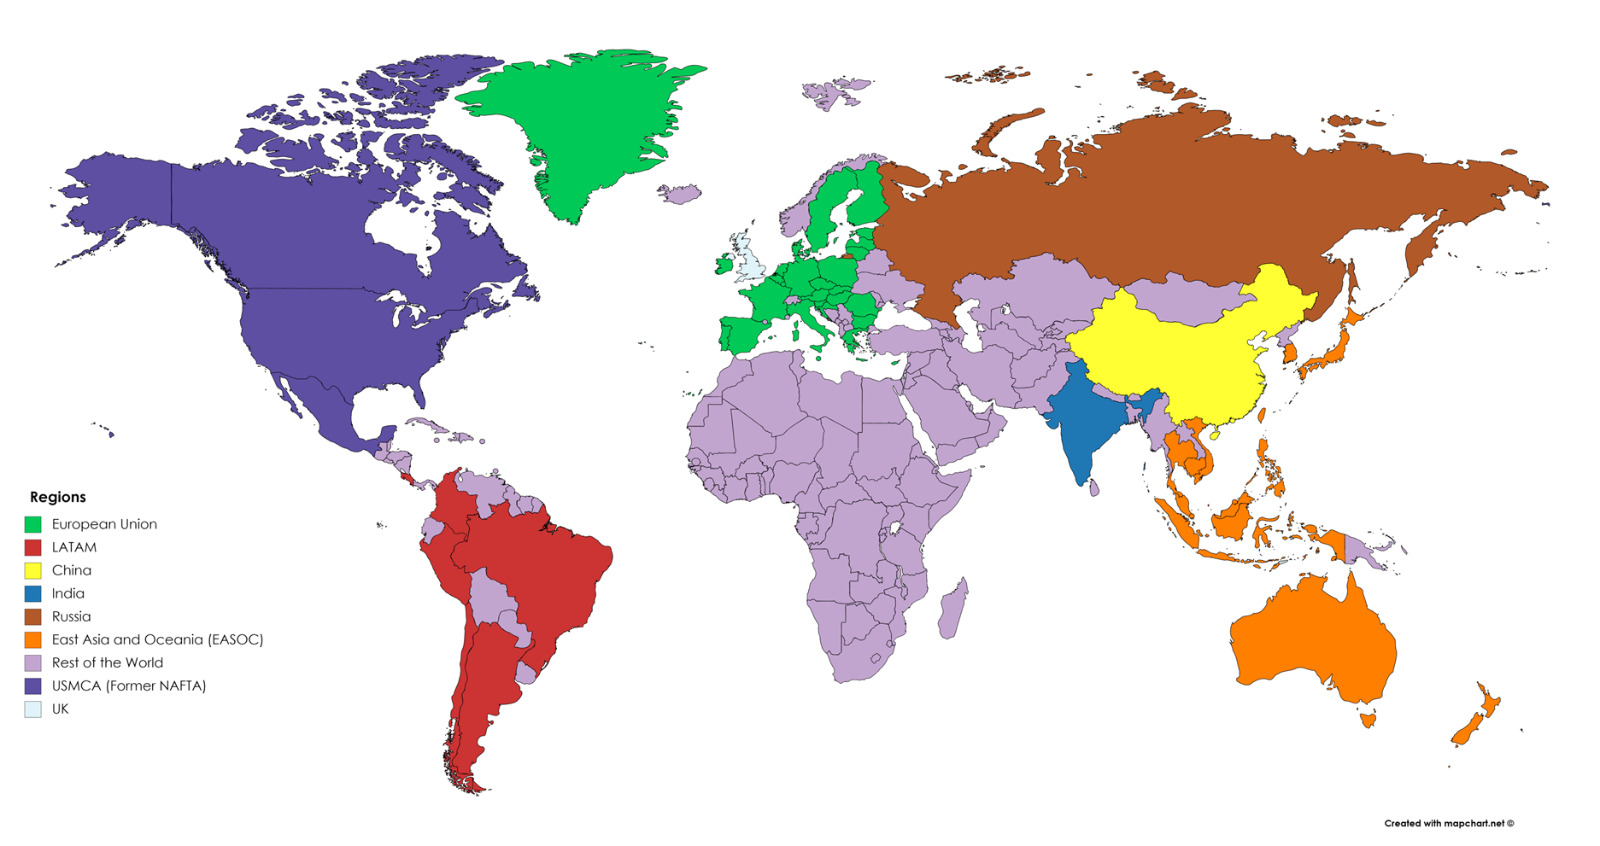

In [29]:

# Defining the regions based on the map's legend
regions = {
    'European Union': ['Ireland', 'Portugal', 'Spain', 'France', 'Belgium', 'Netherlands', 'Luxembourg', 'Germany', 'Denmark', 'Poland', 'Czech Republic', 'Slovakia', 'Hungary', 'Austria', 'Slovenia', 'Italy', 'Croatia', 'Romania', 'Bulgaria', 'Greece', 'Sweden', 'Finland', 'Estonia', 'Latvia', 'Lithuania'],
    'LATAM': ['Mexico', 'Guatemala', 'Honduras', 'El Salvador', 'Nicaragua', 'Costa Rica', 'Panama', 'Colombia', 'Venezuela', 'Ecuador', 'Peru', 'Brazil', 'Bolivia', 'Paraguay', 'Chile', 'Argentina', 'Uruguay'],
    'CHINA': ['China'],
    'INDIA': ['India'],
    'RUSSIA': ['Russia'],
    'EASOC': ['Japan', 'South Korea', 'Taiwan', 'Australia', 'New Zealand'],
    'LROW': ['Greenland', 'Iceland', 'Norway', 'Switzerland', 'Liechtenstein', 'Bosnia and Herzegovina', 'Serbia', 'Montenegro', 'Kosovo', 'Albania', 'North Macedonia', 'Moldova', 'Ukraine', 'Belarus', 'Georgia', 'Armenia', 'Azerbaijan', 'Turkey', 'Cyprus', 'Malta', 'Lebanon', 'Israel', 'Palestine', 'Jordan', 'Syria', 'Iraq', 'Saudi Arabia', 'Kuwait', 'Bahrain', 'Qatar', 'United Arab Emirates', 'Oman', 'Yemen', 'Egypt', 'Libya', 'Tunisia', 'Algeria', 'Morocco', 'Western Sahara', 'Mauritania', 'Mali', 'Senegal', 'Gambia', 'Guinea-Bissau', 'Guinea', 'Sierra Leone', 'Liberia', 'Ivory Coast', 'Ghana', 'Togo', 'Benin', 'Burkina Faso', 'Niger', 'Nigeria', 'Chad', 'Cameroon', 'Central African Republic', 'South Sudan', 'Sudan', 'Eritrea', 'Djibouti', 'Somalia', 'Ethiopia', 'Uganda', 'Rwanda', 'Burundi', 'Democratic Republic of the Congo', 'Republic of the Congo', 'Gabon', 'Equatorial Guinea', 'Sao Tome and Principe', 'Angola', 'Zambia', 'Zimbabwe', 'Malawi', 'Mozambique', 'Madagascar', 'Namibia', 'Botswana', 'Eswatini', 'Lesotho', 'South Africa', 'Comoros', 'Mauritius', 'Seychelles', 'Tanzania', 'Kenya'],
    'USMCA': ['United States of America', 'Canada'],
    'UK': ['United Kingdom']
}

# Creating the dataframe
data = []

for region, countries in regions.items():
    for country in countries:
        data.append([country, region])

gpt_wiliam = pd.DataFrame(data, columns=['Country', 'Region'])

#import ace_tools as tools; tools.display_dataframe_to_user(name="Country-Region DataFrame", dataframe=df)

In [30]:
gpt_wiliam['Region'] = gpt_wiliam.apply(lambda row: row['Country'].upper() if row['Region'] == 'European Union' else row['Region'], axis=1)
gpt_wiliam.head()

,Country,Region
0,Ireland,IRELAND
1,Portugal,PORTUGAL
2,Spain,SPAIN
3,France,FRANCE
4,Belgium,BELGIUM


In [31]:
wiliam_expanded = wiliam.merge(gpt_wiliam, left_on='WILIAM region', right_on='Region', how='right')
wiliam_expanded.head()

,WILIAM region,WILIAM code,Countries,ICIO Code,ALPHA-2 code,REGIONS 35 I,Country,Region
0,NaN,NaN,NaN,NaN,NaN,NaN,Ireland,IRELAND
1,NaN,NaN,NaN,NaN,NaN,NaN,Portugal,PORTUGAL
2,NaN,NaN,NaN,NaN,NaN,NaN,Spain,SPAIN
3,NaN,NaN,NaN,NaN,NaN,NaN,France,FRANCE
4,NaN,NaN,NaN,NaN,NaN,NaN,Belgium,BELGIUM


## Adding the regions from FUND

In [32]:
fund = pd.read_csv('FUND_regions.csv')
fund['Countries'] = fund['Countries'].str.split(',')
fund_exploded = fund.explode('Countries')
fund_exploded.head()

,Code,Name,Countries
0,USA,USA,United States of America
1,CAN,Canada,Canada
2,WEU,Western Europe,Andorra
2,WEU,Western Europe,Austria
2,WEU,Western Europe,Belgium


In [33]:
def get_iso_code(country_name):
    if country_name == 'Russia':
        country_name = 'Russian Federation'
    elif country_name == 'Turkey':
        country_name = 'Türkiye'
    elif country_name == 'Congo-Kinshasa':
        country_name = 'Congo, The Democratic Republic of the'
    elif country_name == 'Congo-Brazzaville':
        country_name = 'Congo'
    elif country_name == 'Swaziland':
        country_name = 'Eswatini'

    try:
        return pycountry.countries.lookup(country_name).alpha_3
    except LookupError:
        return None
    
all_country_names = [country.name for country in pycountry.countries]
    
def get_best_match(country_name):
    best_match, score = process.extractOne(country_name, all_country_names)
    return best_match if score > 80 else None
    
def get_iso_code_fuzzy(country_name):

    try:
        return pycountry.countries.lookup(get_best_match(country_name)).alpha_3
    except LookupError:
        return None


fund_exploded['ISO'] = fund_exploded['Countries'].apply(get_iso_code)
fund_exploded['ISO'] = fund_exploded['ISO'].fillna(fund_exploded['Countries'].apply(get_iso_code_fuzzy))
fund_exploded

,Code,Name,Countries,ISO
0,USA,USA,United States of America,USA
1,CAN,Canada,Canada,CAN
2,WEU,Western Europe,Andorra,AND
2,WEU,Western Europe,Austria,AUT
2,WEU,Western Europe,Belgium,BEL
...,...,...,...,...
15,SIS,Small Island States,Tonga,TON
15,SIS,Small Island States,Trinidad and Tobago,TTO
15,SIS,Small Island States,Tuvalu,TUV
15,SIS,Small Island States,Vanuatu,VUT


In [34]:
rows_with_na = fund_exploded[fund_exploded['ISO'].isna()]
mismatch = rows_with_na['Countries'].values





# Get the ISO codes for the non-matching countries
fuzzy_matches = {country: get_iso_code(get_best_match(country)) for country in mismatch}

fuzzy_matches

{' FYR Macedonia': None,
 ' Turkey': None,
 ' Laos': None,
 ' Macau': None,
 ' Cape Verde': None,
 ' Swaziland': None}

In [35]:
wiliam['ICIO Code'] = wiliam['ICIO Code'].str.strip()
fund_exploded['ISO'] = fund_exploded['ISO'].str.strip()

In [36]:
correspondance = wiliam.merge(fund_exploded, left_on='ICIO Code', right_on='ISO', how='right')

# Filling missing values of WILIAM as LROW
correspondance['ISO'] = correspondance['ISO'].fillna(correspondance['ICIO Code'])


correspondance['WILIAM region'] = correspondance['WILIAM region'].fillna('Rest of the world')
correspondance['WILIAM code'] = correspondance['WILIAM code'].fillna('LROW')
correspondance['REGIONS 35 I'] = correspondance['REGIONS 35 I'].fillna('LROW')




# Dropping redundant columns
correspondance = correspondance.drop(columns=['Countries_x', 'ICIO Code', 'ALPHA-2 code'])

# Renaming columns
correspondance = correspondance.rename(columns={'Countries_y': 'Country', 'Code' : 'FUND code', 'Name': 'FUND region'})

# Manualy fixing some countries
correspondance.loc[correspondance['Country'] == ' Congo-Kinshasa', 'ISO'] = 'COD'


correspondance.to_csv('correspondance.csv', index=False)
correspondance

,WILIAM region,WILIAM code,REGIONS 35 I,FUND code,FUND region,Country,ISO
0,"United States, Mexico and Canada",USMCA,USMCA,USA,USA,United States of America,USA
1,"United States, Mexico and Canada",USMCA,USMCA,CAN,Canada,Canada,CAN
2,Rest of the world,LROW,LROW,WEU,Western Europe,Andorra,AND
3,European Union,EU27,AUSTRIA,WEU,Western Europe,Austria,AUT
4,European Union,EU27,BELGIUM,WEU,Western Europe,Belgium,BEL
...,...,...,...,...,...,...,...
205,Rest of the world,LROW,LROW,SIS,Small Island States,Tonga,TON
206,Rest of the world,LROW,LROW,SIS,Small Island States,Trinidad and Tobago,TTO
207,Rest of the world,LROW,LROW,SIS,Small Island States,Tuvalu,TUV
208,Rest of the world,LROW,LROW,SIS,Small Island States,Vanuatu,VUT


## Correspondance with WILIAM regions



In [37]:
base_map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
base_map = base_map.merge(correspondance, left_on='iso_a3', right_on='ISO', how='left')
base_map['WILIAM code'] = base_map['WILIAM code'].fillna('LROW')
base_map['WILIAM region'] = base_map['WILIAM region'].fillna('Rest of the world')
base_map.columns

C:\Users\gabriel.genelot\AppData\Local\Temp\ipykernel_36532\2783589314.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  base_map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


Index(['pop_est', 'continent', 'name', 'iso_a3', 'gdp_md_est', 'geometry',
       'WILIAM region', 'WILIAM code', 'REGIONS 35 I', 'FUND code',
       'FUND region', 'Country', 'ISO'],
      dtype='object')

In [38]:
grouped_pop_estimates = base_map[base_map['WILIAM code'] != 'EU27'].groupby('WILIAM code')['pop_est'].sum()
national_estimates = base_map[['REGIONS 35 I', 'pop_est', 'Country']].set_index('Country')
pop_estimates = pd.concat([grouped_pop_estimates, national_estimates]).reset_index()

pop_estimates.to_csv('pop_estimates.csv', index=False)


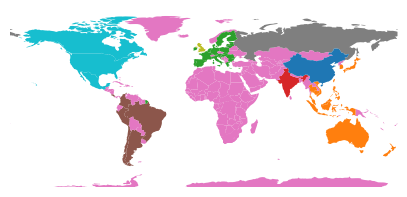

In [45]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(5, 3))

base_map.plot(column='WILIAM region', legend=False, ax=ax)

ax.set_axis_off()
ax.set_xlim(-180, 180)
ax.set_ylim(-75, 90)

plt.savefig('../../../../../Memoire/results/carte_wiliam.png', dpi=300)



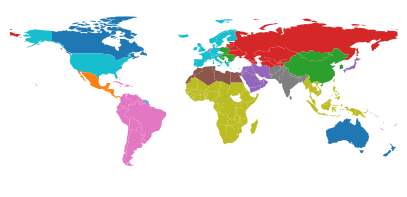

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

base_map.plot(column='FUND region', legend=False, ax=ax)

ax.set_axis_off()
ax.set_xlim(-180, 180)
ax.set_ylim(-75, 90)

plt.savefig('../../../../../Memoire/results/carte_fund.png', dpi=300)

<Axes: >

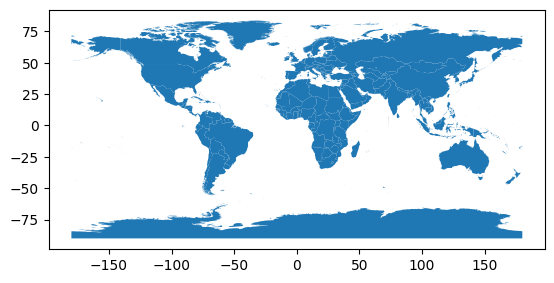

In [14]:
countries = gpd.read_file(r'naturalearthdata\ne_10m_admin_0_countries.shp')
countries.plot()

In [15]:
map = countries.merge(correspondance, left_on='ADM0_A3', right_on='ISO', how='left') 
#map.plot(column='Region_FUND_code', legend=True)

In [16]:
#map.plot(column='Region')

In the end I'd rather use the lowress file because I intend to plot mostly large scale maps. 

In [17]:

base_map.rename(columns={'WILIAM region': 'region'}, inplace=True)

base_map.to_file('output_countries/countries.shp', driver='ESRI Shapefile')

C:\Users\gabriel.genelot\AppData\Local\Temp\ipykernel_36532\2753574168.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  base_map.to_file('output_countries/countries.shp', driver='ESRI Shapefile')


<Axes: >

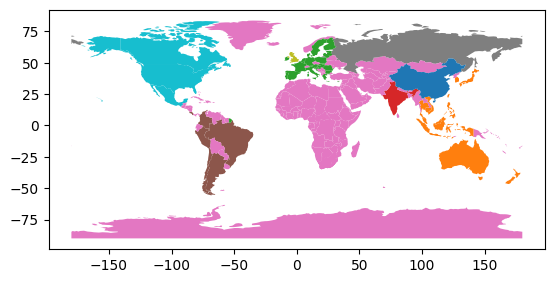

In [18]:
base_map.plot(column='region', legend=False)

<Axes: >

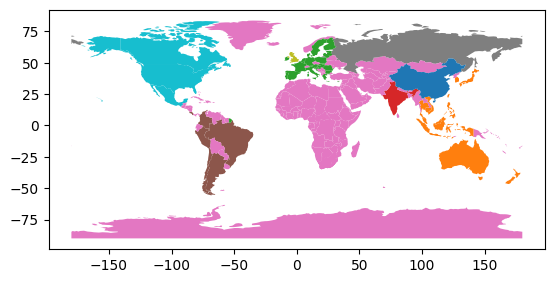

In [19]:
base_map.plot(column='region', legend=False)

In [20]:
map = gpd.read_file('output_countries/countries.shp')
map

,pop_est,continent,name,iso_a3,gdp_md_est,region,WILIAM cod,REGIONS 35,FUND code,FUND regio,Country,ISO,geometry
0,889953.0,Oceania,Fiji,FJI,5496,Rest of the world,LROW,LROW,SIS,Small Island States,Fiji,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,Rest of the world,LROW,LROW,SSA,Sub-Saharan Africa,Tanzania,TZA,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,Rest of the world,LROW,LROW,NAF,North Africa,Western Sahara,ESH,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"United States, Mexico and Canada",USMCA,USMCA,CAN,Canada,Canada,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"United States, Mexico and Canada",USMCA,USMCA,USA,USA,United States of America,USA,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,6944975.0,Europe,Serbia,SRB,51475,Rest of the world,LROW,None,None,None,None,None,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
180,622137.0,Europe,Montenegro,MNE,5542,Rest of the world,LROW,None,None,None,None,None,"POLYGON ((20.07070 42.58863, 19.80161 42.50009..."
181,1794248.0,Europe,Kosovo,-99,7926,Rest of the world,LROW,None,None,None,None,None,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
182,1394973.0,North America,Trinidad and Tobago,TTO,24269,Rest of the world,LROW,LROW,SIS,Small Island States,Trinidad and Tobago,TTO,"POLYGON ((-61.68000 10.76000, -61.10500 10.890..."


In [21]:
map

,pop_est,continent,name,iso_a3,gdp_md_est,region,WILIAM cod,REGIONS 35,FUND code,FUND regio,Country,ISO,geometry
0,889953.0,Oceania,Fiji,FJI,5496,Rest of the world,LROW,LROW,SIS,Small Island States,Fiji,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,Rest of the world,LROW,LROW,SSA,Sub-Saharan Africa,Tanzania,TZA,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,Rest of the world,LROW,LROW,NAF,North Africa,Western Sahara,ESH,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"United States, Mexico and Canada",USMCA,USMCA,CAN,Canada,Canada,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"United States, Mexico and Canada",USMCA,USMCA,USA,USA,United States of America,USA,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,6944975.0,Europe,Serbia,SRB,51475,Rest of the world,LROW,None,None,None,None,None,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
180,622137.0,Europe,Montenegro,MNE,5542,Rest of the world,LROW,None,None,None,None,None,"POLYGON ((20.07070 42.58863, 19.80161 42.50009..."
181,1794248.0,Europe,Kosovo,-99,7926,Rest of the world,LROW,None,None,None,None,None,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
182,1394973.0,North America,Trinidad and Tobago,TTO,24269,Rest of the world,LROW,LROW,SIS,Small Island States,Trinidad and Tobago,TTO,"POLYGON ((-61.68000 10.76000, -61.10500 10.890..."
